### загрузка используемых библиотек

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor

### загрузка датасета

In [3]:
ds = pd.read_excel("C:\ebw_data.xlsx")
ds.head()

,IW,IF,VW,FP,Depth,Width
0,47,139,4.5,80,1.60,2.54
1,47,139,4.5,80,1.62,2.50
2,47,139,4.5,80,1.68,2.60
3,47,139,4.5,80,1.58,2.52
4,45,140,4.5,80,1.76,2.48


In [4]:
ds.shape

(72, 6)

In [5]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   IW      72 non-null     int64  
 1   IF      72 non-null     int64  
 2   VW      72 non-null     float64
 3   FP      72 non-null     int64  
 4   Depth   72 non-null     float64
 5   Width   72 non-null     float64
dtypes: float64(3), int64(3)
memory usage: 3.5 KB


In [6]:
ds = ds.astype('float64')

In [7]:
ds.describe()

,IW,IF,VW,FP,Depth,Width
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,45.666667,141.333333,8.638889,78.333333,1.195556,1.970417
std,1.678363,5.145763,2.061078,21.493530,0.225081,0.279040
min,43.000000,131.000000,4.500000,50.000000,0.800000,1.680000
25%,44.000000,139.000000,8.000000,60.000000,1.080000,1.760000
50%,45.500000,141.000000,9.000000,80.000000,1.200000,1.840000
75%,47.000000,146.000000,10.000000,80.000000,1.290000,2.050000
max,49.000000,150.000000,12.000000,125.000000,1.760000,2.600000


In [8]:
ds.isnull().sum()

IW       0
IF       0
VW       0
FP       0
Depth    0
Width    0
dtype: int64

### визуализируем 

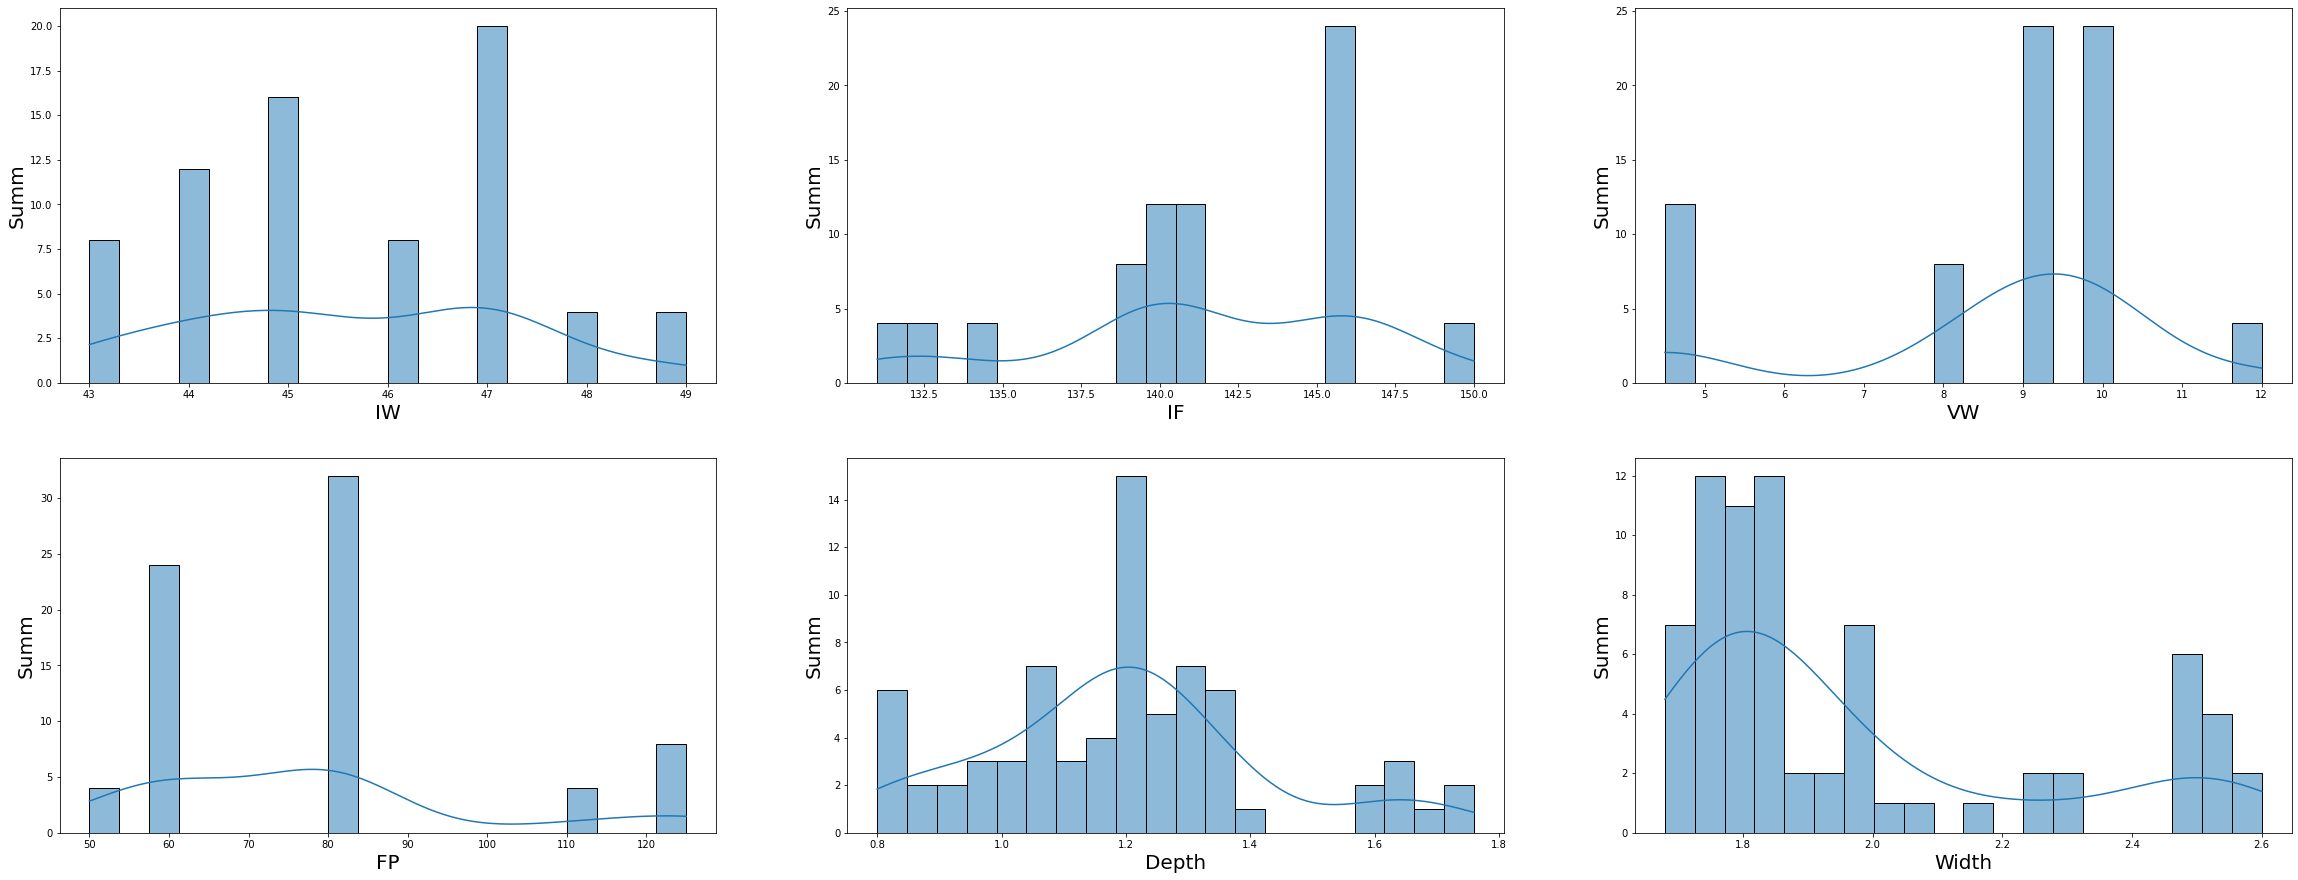

In [9]:
l = 5
w = 3
c = 1

plt.figure(figsize=(40, 40))

for col_name in ds:
    
    plt.subplot(l, w, c)
    sns.histplot(x=col_name, kde=True, bins=20, data=ds)
    
    plt.xlabel(col_name, fontsize=20)
    plt.ylabel("Summ", fontsize=20)
    
    c += 1

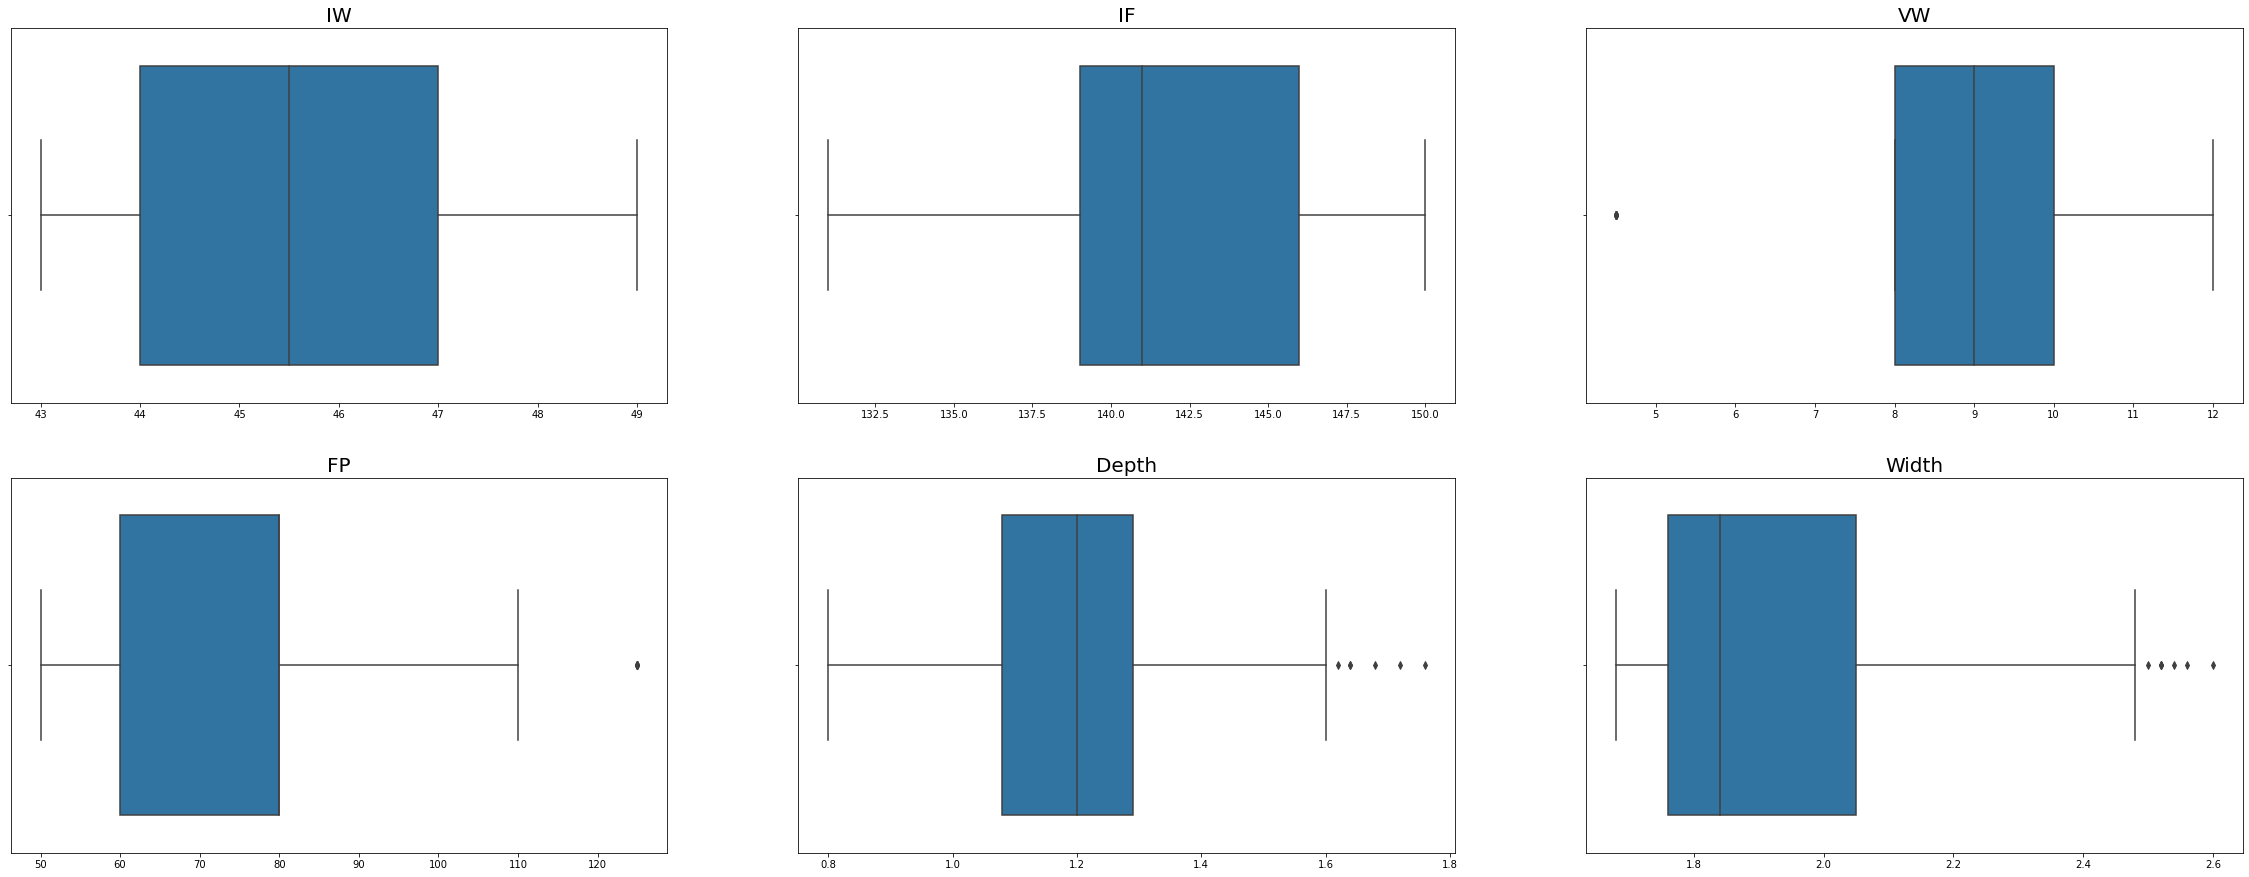

In [10]:
l = 5
w = 3
c = 1

plt.figure(figsize=(40, 40))

for col_name in ds:
    
    plt.subplot(l, w, c)
    
    sns.boxplot(x=ds[col_name])
    plt.title(col_name, fontsize=20)
    plt.xlabel(None)
     
    c += 1

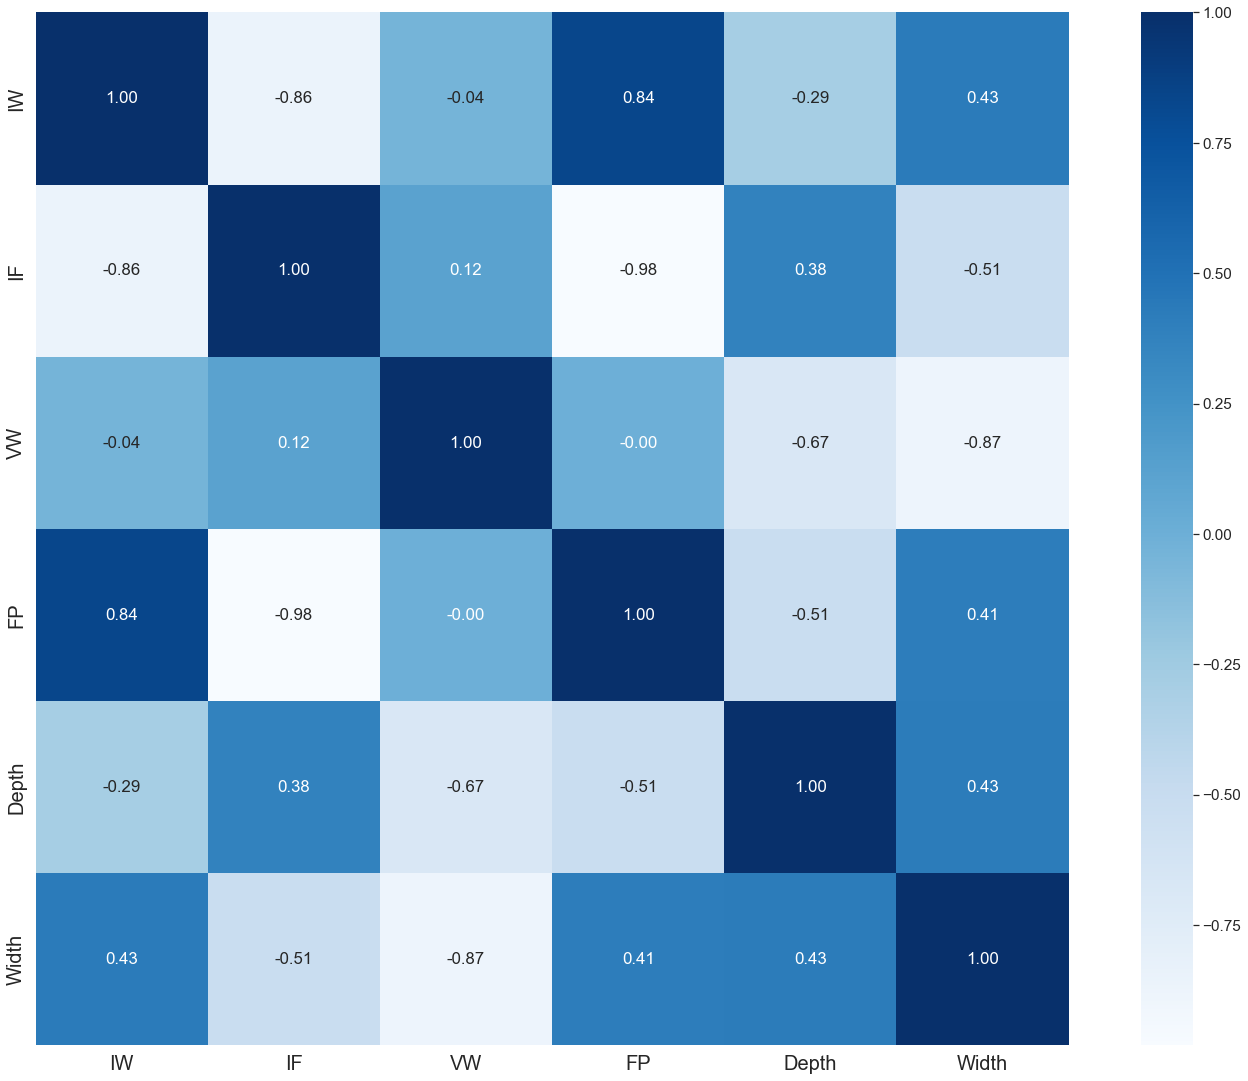

In [11]:
correlations = ds.corr()
plt.figure(figsize=(26, 19))
sns.set(font_scale=1.4)
ax = sns.heatmap(correlations, square=True, annot=True,
                 fmt='.2f', cmap="Blues")
ax.set_xticklabels(ax.get_xticklabels(), fontsize=20)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=20)
plt.show()

### избавимся от выбросов

In [12]:
for col in ds.columns:
    q75,q25 = np.percentile(ds.loc[:,col],[75,25])
    intr_qr = q75-q25

    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)

    ds.loc[ds[col] < min,col] = np.nan
    ds.loc[ds[col] > max,col] = np.nan

In [13]:
ds.isnull().sum()

IW        0
IF        0
VW       12
FP        8
Depth     6
Width     7
dtype: int64

### данных мало, поэтому заменим нулевые значения медианными

In [14]:
for col in ds.columns:
    missing = ds[col].isnull()
    num_missing = np.sum(missing)
    
    if num_missing > 0:  
        med = ds[col].median()
        ds[col] = ds[col].fillna(med)

In [15]:
ds.shape

(72, 6)

### и еще раз визуализируем

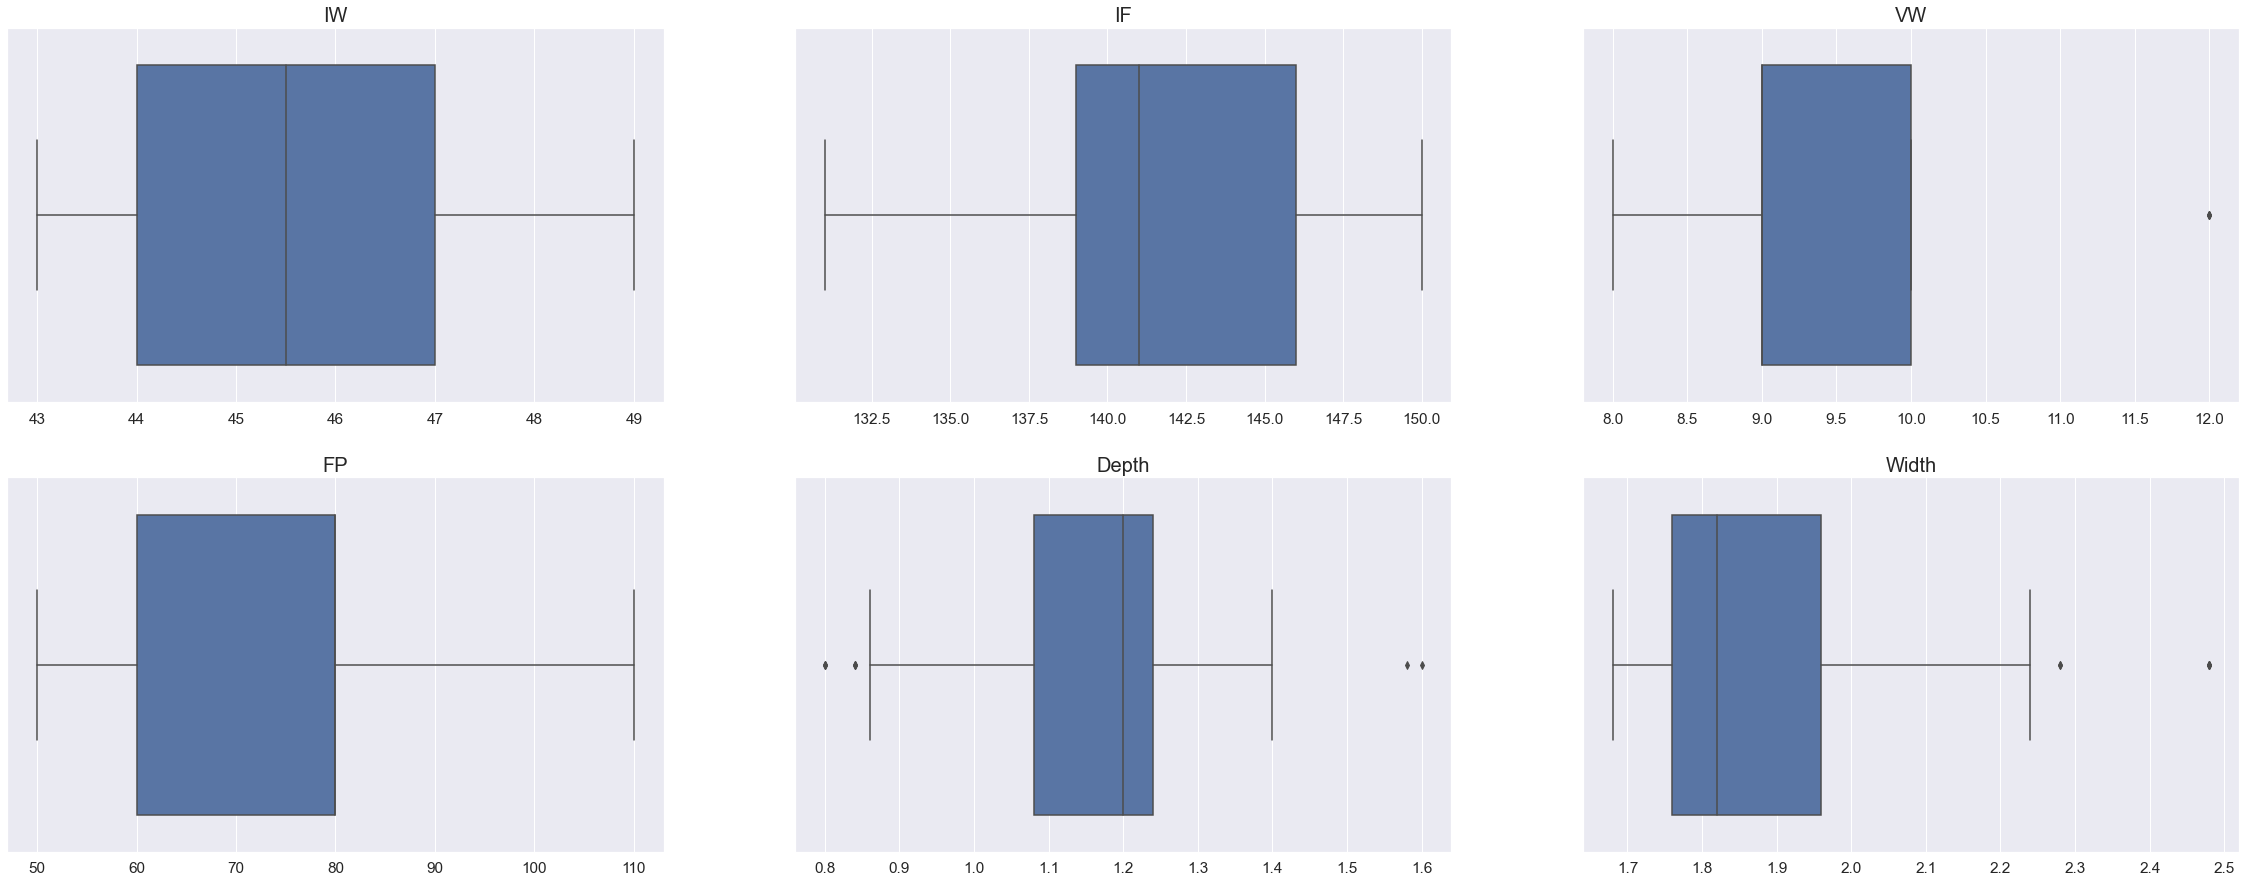

In [16]:
l = 5
w = 3
c = 1

plt.figure(figsize=(40, 40))

for col_name in ds:
    
    plt.subplot(l, w, c)
    
    sns.boxplot(x=ds[col_name])
    plt.title(col_name, fontsize=20)
    plt.xlabel(None)
     
    c += 1

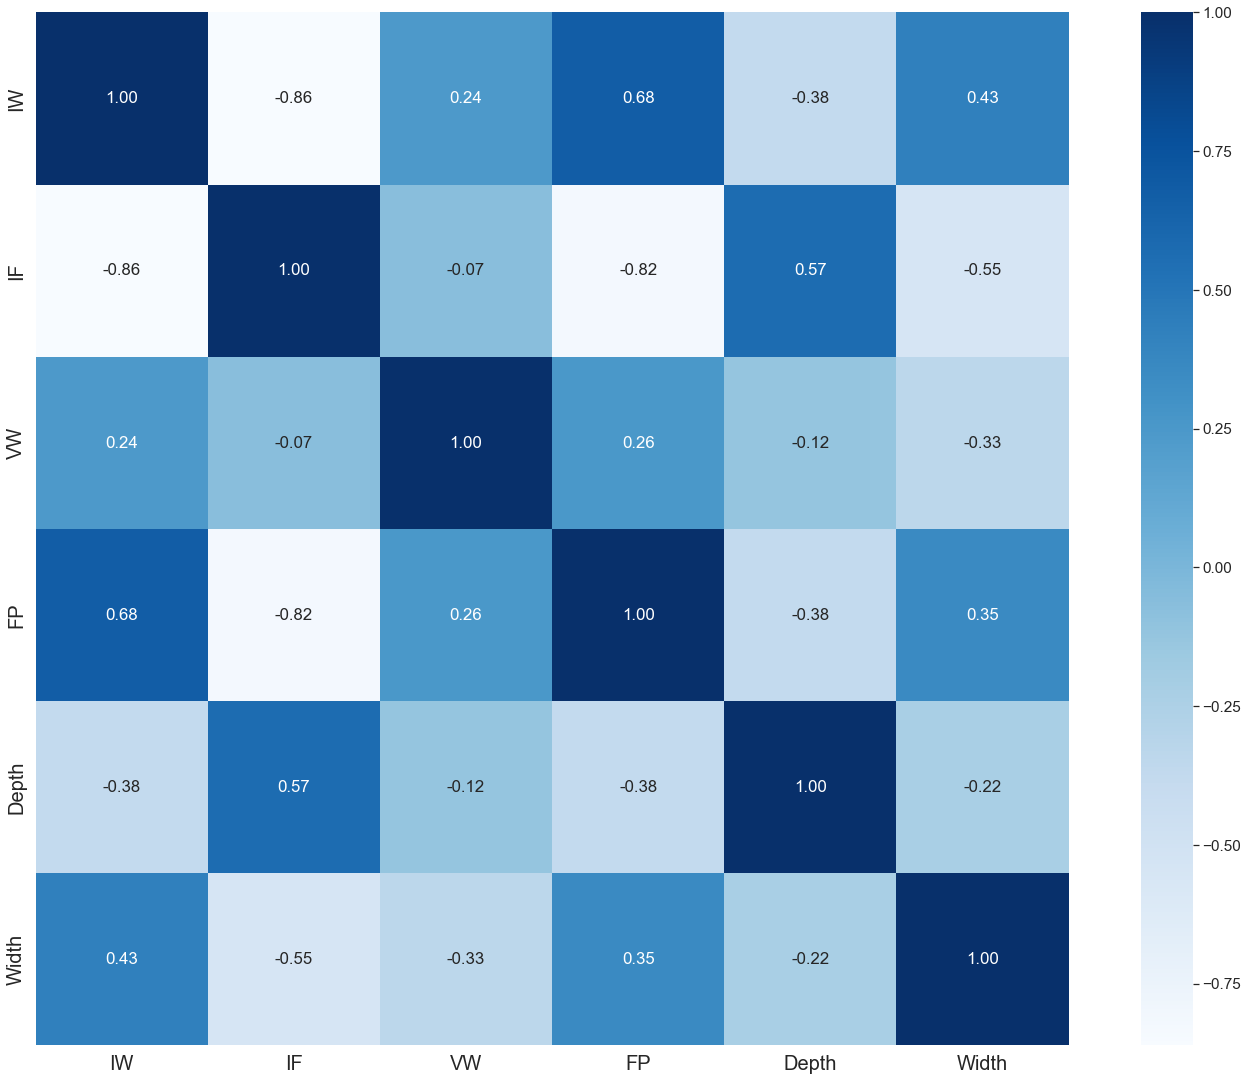

In [17]:
correlations = ds.corr()
plt.figure(figsize=(26, 19))
sns.set(font_scale=1.4)
ax = sns.heatmap(correlations, square=True, annot=True,
                 fmt='.2f', cmap="Blues")
ax.set_xticklabels(ax.get_xticklabels(), fontsize=20)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=20)
plt.show()

## разбиваем данные на выборки

In [21]:
X = ds.iloc[:, 0:4]
y_depth = ds['Depth']
y_width = ds['Width']

X_train, X_test, y_depth_train, y_depth_test = train_test_split(X, y_depth, test_size=0.2, random_state = 0)
X_train, X_test, y_width_train, y_width_test = train_test_split(X, y_width, test_size=0.2, random_state = 0)

In [22]:
print(X_train.shape, X_test.shape, y_depth_train.shape, y_depth_test.shape)
print(X_train.shape, X_test.shape, y_width_train.shape, y_width_test.shape)

(57, 4) (15, 4) (57,) (15,)
(57, 4) (15, 4) (57,) (15,)


## нормализуем значения

In [23]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
X_train.shape

(57, 4)

## Линейная модель

In [25]:
linear_model = LinearRegression()

### depth

In [26]:
linear_model.fit(X_train, y_depth_train)
linear_y_depth_pred = linear_model.predict(X_test)
linear_mae_depth = mean_absolute_error(y_depth_test, linear_y_depth_pred)
linear_mse_depth = mean_squared_error(y_depth_test, linear_y_depth_pred)
linear_r2_depth = r2_score(y_depth_test, linear_y_depth_pred)
print('MAE: ', linear_mae_depth)
print('MSE: ', linear_mse_depth)
print('R2: ', linear_r2_depth)

MAE:  0.09186087731266056
MSE:  0.011313554275598301
R2:  0.6492960277733912


### width

In [27]:
linear_model.fit(X_train, y_width_train)
linear_y_width_pred = linear_model.predict(X_test)
linear_mae_width = mean_absolute_error(y_width_test, linear_y_width_pred)
linear_mse_width = mean_squared_error(y_width_test, linear_y_width_pred)
linear_r2_width = r2_score(y_width_test, linear_y_width_pred)
print('MAE: ', linear_mae_width)
print('MSE: ', linear_mse_width)
print('R2: ', linear_r2_width)

MAE:  0.13538935836785201
MSE:  0.046375430662591866
R2:  0.12825224743657504


## GradientBoostingRegressor

In [28]:
gradient_model = GradientBoostingRegressor(max_depth=3)

### depth

In [29]:
gradient_model.fit(X_train, y_depth_train)
gradient_y_depth_pred = gradient_model.predict(X_test)
gradient_mae_depth = mean_absolute_error(y_depth_test, gradient_y_depth_pred)
gradient_mse_depth = mean_squared_error(y_depth_test, gradient_y_depth_pred)
gradient_r2_depth = r2_score(y_depth_test, gradient_y_depth_pred)
print('MAE: ', gradient_mae_depth)
print('MSE: ', gradient_mse_depth)
print('R2: ', gradient_r2_depth)

MAE:  0.07694551932528251
MSE:  0.010705524536548432
R2:  0.6681440784851487


### width

In [30]:
gradient_model.fit(X_train, y_width_train)
gradient_y_width_pred = gradient_model.predict(X_test)
gradient_mae_width = mean_absolute_error(y_width_test, gradient_y_width_pred)
gradient_mse_width = mean_squared_error(y_width_test, gradient_y_width_pred)
gradient_r2_width = r2_score(y_width_test, gradient_y_width_pred)
print('MAE: ', gradient_mae_width)
print('MSE: ', gradient_mse_width)
print('R2: ', gradient_r2_width)

MAE:  0.15143435118285511
MSE:  0.08029309480260557
R2:  -0.5093191360267895


## KNeighborsRegressor

In [31]:
knn_model = KNeighborsRegressor(n_neighbors=3)

### depth

In [32]:
knn_model.fit(X_train, y_depth_train)
knn_y_depth_pred = knn_model.predict(X_test)
knn_mae_depth = mean_absolute_error(y_depth_test, knn_y_depth_pred)
knn_mse_depth = mean_squared_error(y_depth_test, knn_y_depth_pred)
knn_r2_depth = r2_score(y_depth_test, knn_y_depth_pred)
print('MAE: ', knn_mae_depth)
print('MSE: ', knn_mse_depth)
print('R2: ', knn_r2_depth)

MAE:  0.051111111111111114
MSE:  0.003795555555555559
R2:  0.8823432161357874


### width

In [33]:
knn_model.fit(X_train, y_width_train)
knn_y_width_pred = knn_model.predict(X_test)
knn_mae_width = mean_absolute_error(y_width_test, knn_y_width_pred)
knn_mse_width = mean_squared_error(y_width_test, knn_y_width_pred)
knn_r2_width = r2_score(y_width_test, knn_y_width_pred)
print('MAE: ', knn_mae_width)
print('MSE: ', knn_mse_width)
print('R2: ', knn_r2_width)

MAE:  0.14111111111111121
MSE:  0.04639777777777777
R2:  0.12783217484293552


## RandomForestRegressor

In [34]:
forest_model = RandomForestRegressor(max_depth=2)

### depth

In [35]:
forest_model.fit(X_train, y_depth_train)
forest_y_depth_pred = forest_model.predict(X_test)
forest_mae_depth = mean_absolute_error(y_depth_test, forest_y_depth_pred)
forest_mse_depth = mean_squared_error(y_depth_test, forest_y_depth_pred)
forest_r2_depth = r2_score(y_depth_test, forest_y_depth_pred)
print('MAE: ', forest_mae_depth)
print('MSE: ', forest_mse_depth)
print('R2: ', forest_r2_depth)

MAE:  0.08404771663409148
MSE:  0.011822181854343044
R2:  0.6335293016054249


### width

In [36]:
forest_model.fit(X_train, y_width_train.values.ravel())
forest_y_width_pred = forest_model.predict(X_test)
forest_mae_width = mean_absolute_error(y_width_test, forest_y_width_pred)
forest_mse_width = mean_squared_error(y_width_test, forest_y_width_pred)
forest_r2_width = r2_score(y_width_test, forest_y_width_pred)
print('MAE: ', forest_mae_width)
print('MSE: ', forest_mse_width)
print('R2: ', forest_r2_width)

MAE:  0.13322348578502582
MSE:  0.06821108676220945
R2:  -0.2822061323266549


## строим графики метрик

In [37]:
models = pd.DataFrame()
linear_model_depth = pd.DataFrame({
   'Model': 'LinearRegression', 
   'MAE': linear_mae_depth, 
   'MSE': linear_mse_depth,
   'R2' : linear_r2_depth,
}, index=['Depth_Linear'])
gradient_model_depth = pd.DataFrame({
   'Model': 'GradientBoostingRegressor', 
   'MAE': gradient_mae_depth, 
   'MSE': gradient_mse_depth,
   'R2' : gradient_r2_depth,
}, index=['Depth_Gradient'])
knn_model_depth = pd.DataFrame({
   'Model': 'KNeighborsRegressor', 
   'MAE': knn_mae_depth, 
   'MSE': knn_mse_depth,
   'R2' : knn_r2_depth,
}, index=['Depth_KNN'])
forest_model_depth = pd.DataFrame({
   'Model': 'RandomForestRegressor', 
   'MAE': forest_mae_depth, 
   'MSE': forest_mse_depth,
   'R2' : forest_r2_depth,
}, index=['Depth_Forest'])
linear_model_width = pd.DataFrame({
   'Model': 'LinearRegression', 
   'MAE': linear_mae_width, 
   'MSE': linear_mse_width,
   'R2' : linear_r2_width,
}, index=['Width'])
gradient_model_width = pd.DataFrame({
   'Model': 'GradientBoostingRegressor', 
   'MAE': gradient_mae_width, 
   'MSE': gradient_mse_width,
   'R2' : gradient_r2_width,
}, index=['Width'])
knn_model_width = pd.DataFrame({
   'Model': 'KNeighborsRegressor', 
   'MAE': knn_mae_width, 
   'MSE': knn_mse_width,
   'R2' : knn_r2_width,
}, index=['Width'])
forest_model_width = pd.DataFrame({
   'Model': 'RandomForestRegressor', 
   'MAE': forest_mae_width, 
   'MSE': forest_mse_width,
   'R2' : forest_r2_width,
}, index=['Width'])

In [38]:
models_depth = pd.concat([models, linear_model_depth, gradient_model_depth, knn_model_depth, forest_model_depth])
models_width = pd.concat([linear_model_width, gradient_model_width, knn_model_width, forest_model_width])

In [39]:
models_depth_list = models_depth.sort_values(by=['MAE', 'MSE', 'R2'])
models_depth_list

,Model,MAE,MSE,R2
Depth_KNN,KNeighborsRegressor,0.051111,0.003796,0.882343
Depth_Gradient,GradientBoostingRegressor,0.076946,0.010706,0.668144
Depth_Forest,RandomForestRegressor,0.084048,0.011822,0.633529
Depth_Linear,LinearRegression,0.091861,0.011314,0.649296


In [40]:
models_width_list = models_width.sort_values(by=['MAE', 'MSE', 'R2'])
models_width_list

,Model,MAE,MSE,R2
Width,RandomForestRegressor,0.133223,0.068211,-0.282206
Width,LinearRegression,0.135389,0.046375,0.128252
Width,KNeighborsRegressor,0.141111,0.046398,0.127832
Width,GradientBoostingRegressor,0.151434,0.080293,-0.509319


Text(0.5, 1.0, 'MAE Depth')

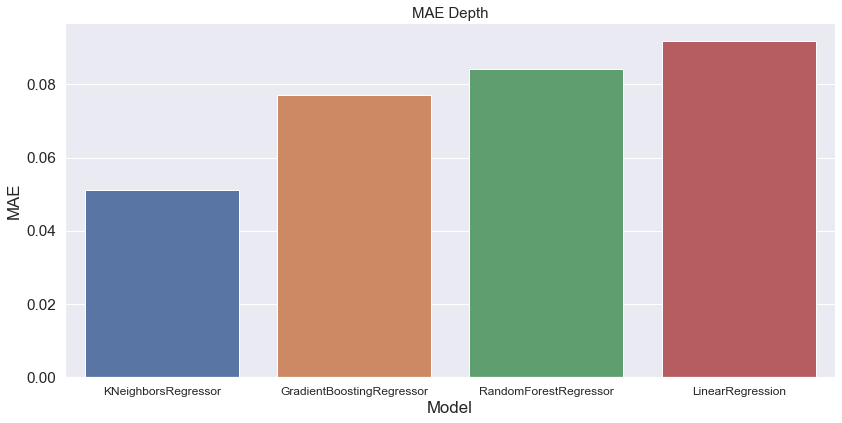

In [41]:
sns.catplot(data=models_depth_list[0:5], x='Model', y='MAE', kind='bar', height=6, aspect=2)
plt.xticks(size=12)
plt.title('MAE Depth', size=15)

Text(0.5, 1.0, 'MAE Depth')

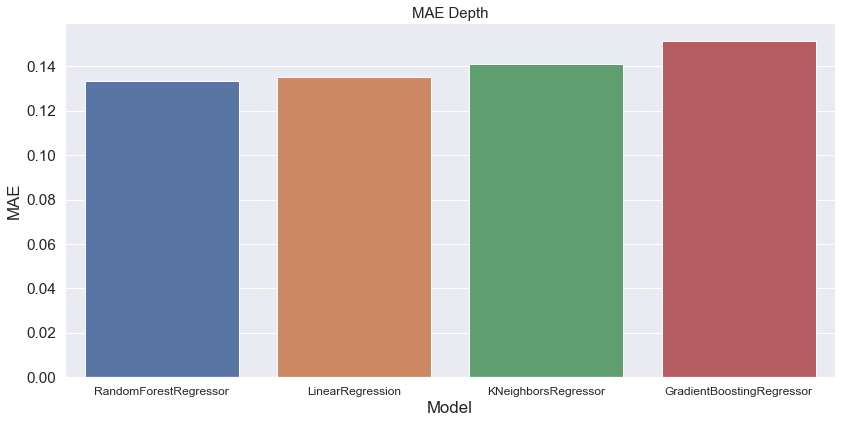

In [42]:
sns.catplot(data=models_width_list[0:5], x='Model', y='MAE', kind='bar', height=6, aspect=2)
plt.xticks(size=12)
plt.title('MAE Depth', size=15)

Text(0.5, 1.0, 'MSE Depth')

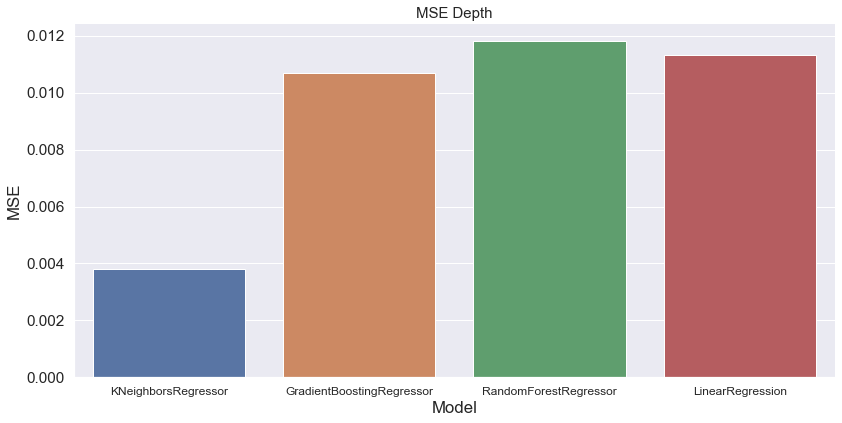

In [43]:
sns.catplot(data=models_depth_list[0:5], x='Model', y='MSE', kind='bar', height=6, aspect=2)
plt.xticks(size=12)
plt.title('MSE Depth', size=15)

Text(0.5, 1.0, 'MSE Width')

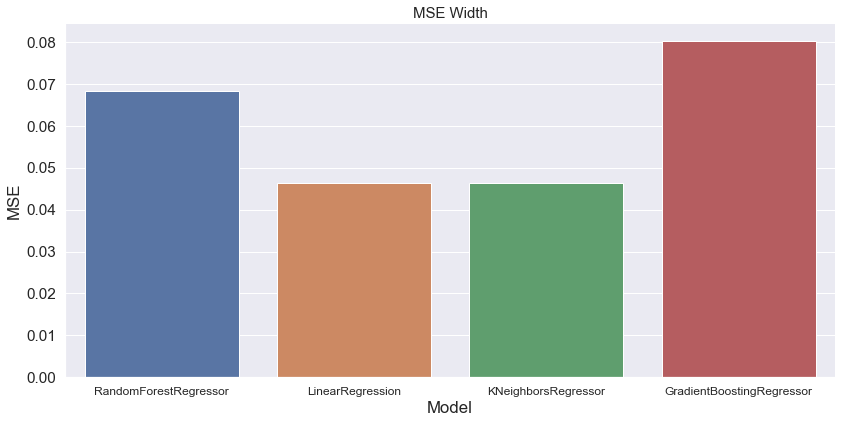

In [44]:
sns.catplot(data=models_width_list[0:5], x='Model', y='MSE', kind='bar', height=6, aspect=2)
plt.xticks(size=12)
plt.title('MSE Width', size=15)

Text(0.5, 1.0, 'R2 Depth')

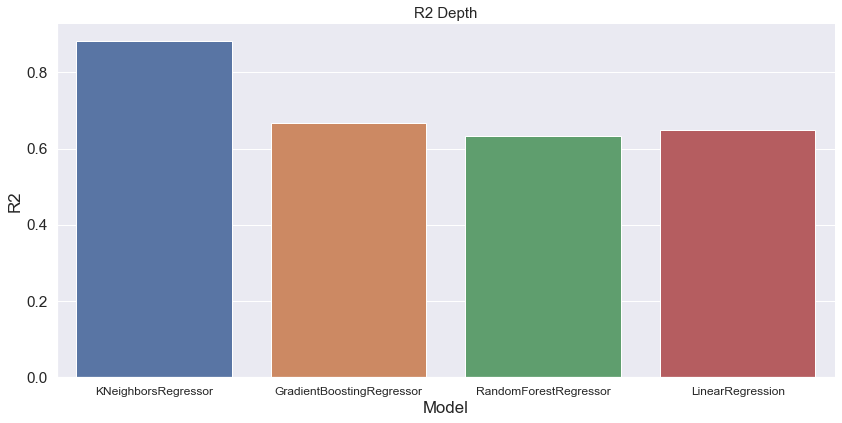

In [45]:
sns.catplot(data=models_depth_list[0:5], x='Model', y='R2', kind='bar', height=6, aspect=2)
plt.xticks(size=12)
plt.title('R2 Depth', size=15)

Text(0.5, 1.0, 'R2 Width')

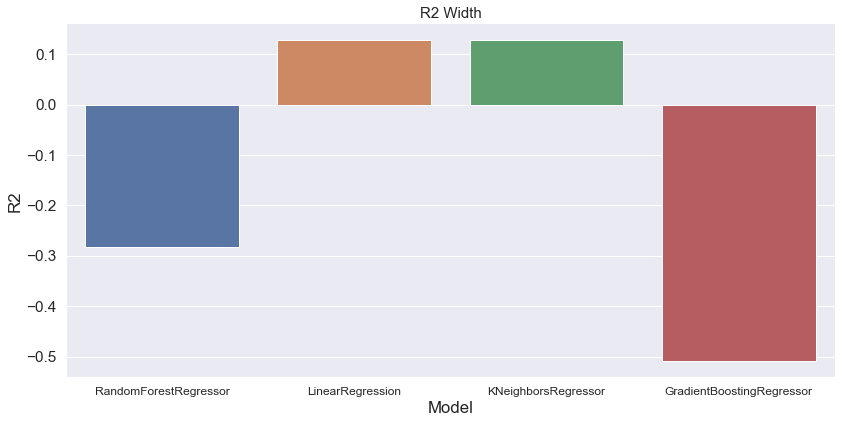

In [46]:
sns.catplot(data=models_width_list[0:5], x='Model', y='R2', kind='bar', height=6, aspect=2)
plt.xticks(size=12)
plt.title('R2 Width', size=15)

## Нейронная сеть

### простая

In [47]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_train))

In [48]:
simple_model_depth = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
]) 
simple_model_depth.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 4)                9         
 n)                                                              
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 14
Trainable params: 5
Non-trainable params: 9
_________________________________________________________________


In [49]:
simple_model_depth.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1), loss='mean_absolute_error')

In [50]:
history = simple_model_depth.fit(X_train, y_depth_train, epochs=20, verbose=0, validation_split = 0.2)

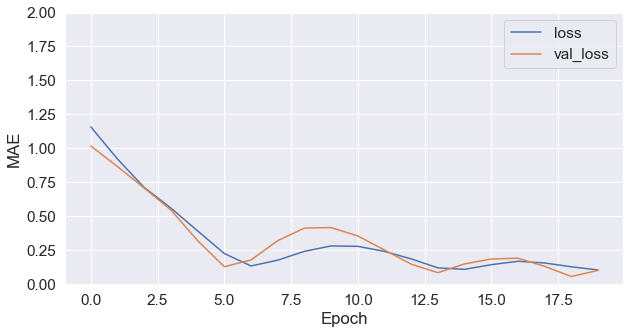

In [51]:
def plot_loss(history):
    plt.figure(figsize=(10,5))
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 2])
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)

plot_loss(history)

1/1 [==============================] - 0s 122ms/step


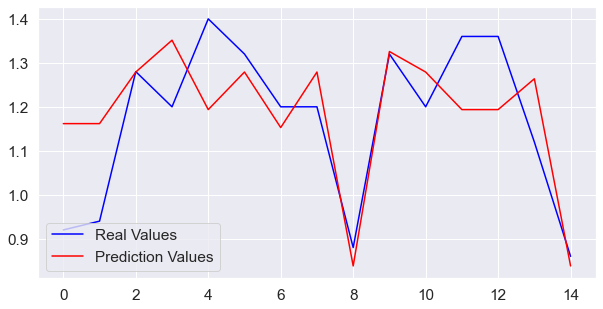

In [52]:
depth_pred=simple_model_depth.predict(np.array(X_test))

plt.figure(figsize=(10,5))
plt.plot(y_depth_test.values, color='blue', label = 'Real Values')
plt.plot(depth_pred, color='red', label = 'Prediction Values')
plt.legend(loc='best')
plt.show()

In [53]:
test_results = {}
test_results['Simple Model for Depth'] = simple_model_depth.evaluate(X_test, y_depth_test, verbose=0)
test_results

{'Simple Model for Depth': 0.1076316386461258}

In [54]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_train))

In [55]:
simple_model_width = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
]) 
simple_model_width.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 4)                9         
 ion)                                                            
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                                 
Total params: 14
Trainable params: 5
Non-trainable params: 9
_________________________________________________________________


In [56]:
simple_model_width.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1), loss='mean_absolute_error')

In [57]:
history = simple_model_width.fit(X_train, y_width_train, epochs=20, verbose=0, validation_split = 0.2)

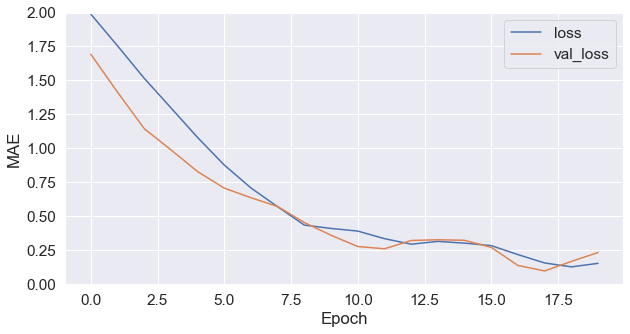

In [58]:
def plot_loss(history):
    plt.figure(figsize=(10,5))
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 2])
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)
    
plot_loss(history)

1/1 [==============================] - 0s 100ms/step


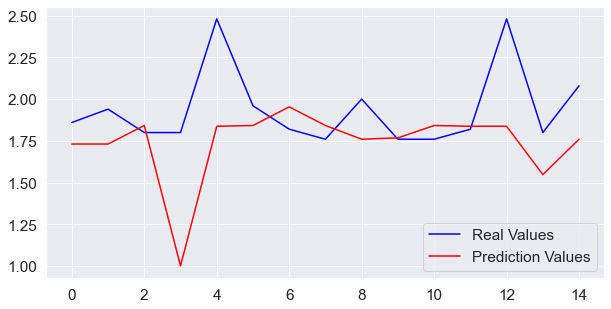

In [59]:
width_pred=simple_model_width.predict(np.array(X_test))

plt.figure(figsize=(10,5))
plt.plot(y_width_test.values, color='blue', label = 'Real Values')
plt.plot(width_pred, color='red', label = 'Prediction Values')
plt.legend(loc='best')
plt.show()

In [60]:
test_results = {}
test_results['Simple Model for Width'] = simple_model_width.evaluate(X_test, y_width_test, verbose=0)
test_results

{'Simple Model for Width': 0.24766585230827332}

### усложним

In [61]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_train))

In [62]:
not_so_simple_model_depth = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(units=128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(units=128, activation='relu'),
    layers.Dense(units=1)
]) 
not_so_simple_model_depth.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (None, 4)                9         
 ion)                                                            
                                                                 
 dense_2 (Dense)             (None, 128)               640       
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                      

In [63]:
not_so_simple_model_depth.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss='mean_absolute_error')

In [64]:
history = not_so_simple_model_depth.fit(X_train, y_depth_train, batch_size=3, epochs=60, verbose=0, validation_split = 0.1)

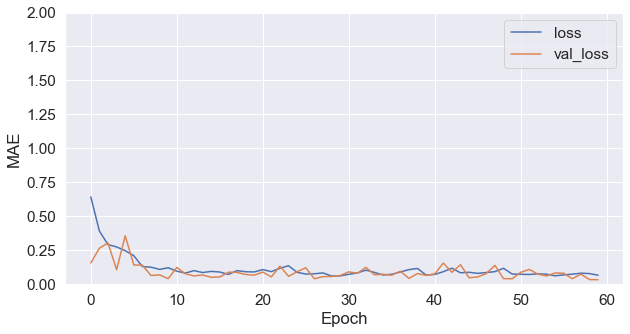

In [65]:
def plot_loss(history):
    plt.figure(figsize=(10,5))
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 2])
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)
    
plot_loss(history)

1/1 [==============================] - 0s 123ms/step


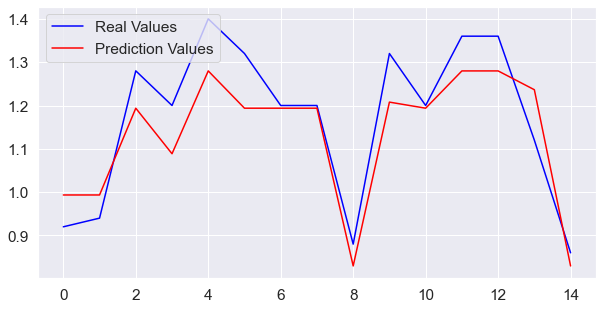

In [66]:
another_depth_pred=not_so_simple_model_depth.predict(np.array(X_test))

plt.figure(figsize=(10,5))
plt.plot(y_depth_test.values, color='blue', label = 'Real Values')
plt.plot(another_depth_pred, color='red', label = 'Prediction Values')
plt.legend(loc='best')
plt.show()

In [67]:
test_results = {}
test_results['Not Simple Model for Depth'] = not_so_simple_model_depth.evaluate(X_test, y_depth_test, verbose=0)
test_results

{'Not Simple Model for Depth': 0.07062052190303802}

In [69]:
not_so_simple_model_depth_path='depth_model'
not_so_simple_model_depth.save(not_so_simple_model_depth_path)

INFO:tensorflow:Assets written to: depth_model\assets


In [70]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_train))

In [71]:
not_so_simple_model_width = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(units=128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(units=128, activation='relu'),
    layers.Dense(units=1)
]) 
not_so_simple_model_width.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normalizat  (None, 4)                9         
 ion)                                                            
                                                                 
 dense_6 (Dense)             (None, 128)               640       
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 128)               16512     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 128)               16512     
                                                      

In [72]:
not_so_simple_model_width.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss='mean_absolute_error')

In [73]:
history = not_so_simple_model_width.fit(X_train, y_width_train, batch_size=3, epochs=60, verbose=0, validation_split = 0.1)

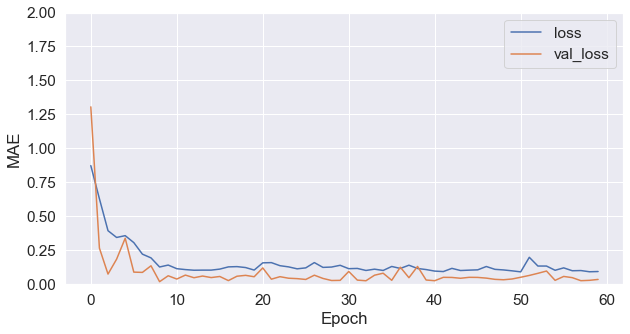

In [74]:
def plot_loss(history):
    plt.figure(figsize=(10,5))
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 2])
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)
    
plot_loss(history)

1/1 [==============================] - 0s 120ms/step


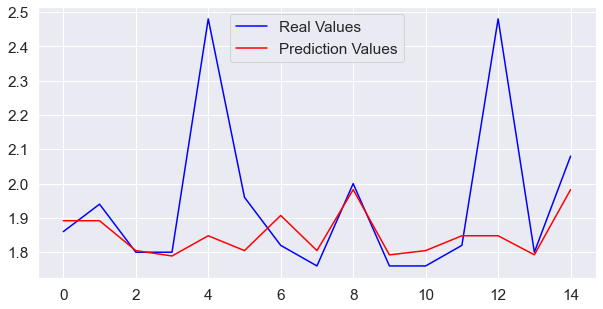

In [75]:
another_width_pred=not_so_simple_model_width.predict(np.array(X_test))

plt.figure(figsize=(10,5))
plt.plot(y_width_test.values, color='blue', label = 'Real Values')
plt.plot(another_width_pred, color='red', label = 'Prediction Values')
plt.legend(loc='best')
plt.show()

In [76]:
test_results = {}
test_results['Not Simple Model for Depth'] = not_so_simple_model_width.evaluate(X_test, y_width_test, verbose=0)
test_results

{'Not Simple Model for Depth': 0.12497630715370178}

In [77]:
not_so_simple_model_width_path='width_model'
not_so_simple_model_width.save(not_so_simple_model_width_path)

INFO:tensorflow:Assets written to: width_model\assets
